In [26]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data_2019 = pd.read_json('/Users/yuhanqi/MA/code/data/transformer/512/2019_cleaned_transformer_512_prediction.json')

In [3]:
data_2019.city.value_counts()

Philadelphia      60905
New Orleans       58016
Nashville         41945
Tampa             36135
Indianapolis      28822
                  ...  
SPRINGHILL            1
Marshallton           1
Tampa,Fl              1
goodlettsville        1
Ridley                1
Name: city, Length: 779, dtype: int64

In [16]:
df = pd.concat([df_2011_2018, data_2019], axis=0, ignore_index=True)

In [20]:
#Aggregate on city level
city_agg=df.groupby('city').agg({'review_id':['count'],'date':['min','max'],
                                                    'year':['min','max'], 'stars':['mean']})
city_agg=city_agg.sort_values([('review_id','count')],ascending=False)

In [22]:
top10_city = city_agg.head(10)
top10_city

review_id                date                      year        \
                  count                 min                 max   min   max   
city                                                                          
Philadelphia     394448 2011-01-01 00:05:27 2019-12-31 23:48:57  2011  2019   
New Orleans      321476 2011-01-01 02:29:53 2019-12-31 23:58:18  2011  2019   
Nashville        200760 2011-01-01 01:34:44 2019-12-31 23:49:00  2011  2019   
Tampa            180231 2011-01-01 01:48:04 2019-12-31 23:56:19  2011  2019   
Tucson           149433 2011-01-01 02:47:46 2019-12-31 23:55:21  2011  2019   
Indianapolis     143444 2011-01-01 00:43:16 2019-12-31 23:48:31  2011  2019   
Reno             113035 2011-01-01 02:35:50 2019-12-31 23:54:43  2011  2019   
Saint Louis      103089 2011-01-01 00:21:30 2019-12-31 23:31:30  2011  2019   
Santa Barbara     96049 2011-01-01 01:14:55 2019-12-31 23:38:44  2011  2019   
Boise             42276 2011-01-02 15:39:56 2019-12-31 22:22:48  2011  2019   

                  stars  
                   mean  
city                     
Philadelphia   3.875294  
New Orleans    3.966290  
Nashville      3.916054  
Tampa          3.886662  
Tucson         3.780684  
Indianapolis   3.898602  
Reno           3.815093  
Saint Louis    3.914947  
Santa Barbara  4.029985  
Boise          3.877992

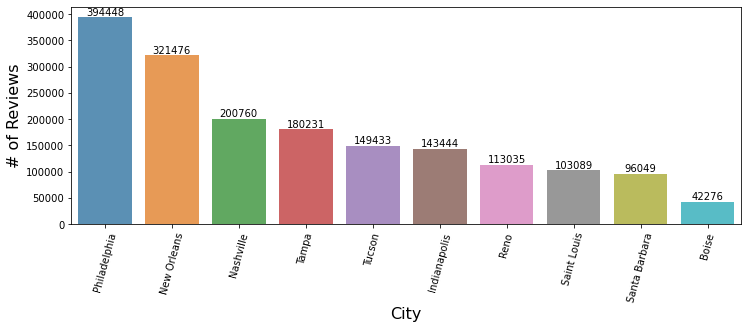

In [29]:
#Plot the distirbution
plt.figure(figsize=(12,4))
ax= sns.barplot(x=top10_city.index, y=top10_city[('review_id','count')], alpha=0.8)
#plt.title("Top 10 Cities in Yelp", fontsize=20)
locs, labels = plt.xticks()
plt.setp(labels, rotation=75)
plt.ylabel('# of Reviews', fontsize=16)
plt.xlabel('City', fontsize=16)

#adding the text labels
rects = ax.patches
labels = top10_city[('review_id','count')]
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

In [4]:
data_history = pd.read_json('/Users/yuhanqi/MA/code/data/restaurant_review_2005_2018.json')
df_2011_2018 = data_history[data_history['year'] >= 2011]

In [5]:
df_2011_2018.city.value_counts()

Philadelphia                  333543
New Orleans                   263460
Nashville                     158815
Tampa                         144096
Tucson                        122351
                               ...  
Zieglerville                       3
wimauma                            3
Elmwood                            2
Lower Southampton Township         2
Thonosassa                         2
Name: city, Length: 778, dtype: int64

In [5]:
# 'stars_bert_512', 'stars_albert_512', 'stars_distilbert_512', 'stars_xlnet_512'
sentiments = ['stars', 'stars_roberta_512']
# cities = ['Philadelphia', 'New Orleans', 'Nashville']
# cities = ['Tampa', 'Tucson']
cities = ['Indianapolis', 'Reno', 'Santa Barbara', 'Saint Louis', 'Boise']
indices = ['bsi','asi','vsi']
backfill_sentiments = ['stars_roberta_512']

In [6]:
def weekly_time_series_2019(df_data, sentiments, cities):
    df_series = pd.DataFrame()
    for i in cities:
        data = df_data[df_data['city']== i]
        for j in sentiments:
            if j == 'stars':
                count = data.groupby(pd.Grouper(key='date', freq = 'W'))[j].count().reset_index()
                df_series['date'] = count['date']
                df_series['count_{}'.format(i)] = count[j]
            BSI_positive = data[data[j]>3].groupby(pd.Grouper(key='date', freq='W'))[j].count().reset_index(name='count')
            BSI_negative = data[data[j]<3].groupby(pd.Grouper(key='date', freq='W'))[j].count().reset_index(name='count')
            BSI = pd.concat([BSI_positive['date'], BSI_positive['count'], BSI_negative['count']]
                        , axis = 1, keys=['date', 'positive_count', 'negative_count'])
            df_series['bsi_{}_{}'.format(i,j)] = np.log((1+BSI['positive_count'])/(1+BSI['negative_count']))
            ASI = data.groupby(pd.Grouper(key='date', freq='W'))[j].mean().reset_index()
            df_series['asi_{}_{}'.format(i,j)] = ASI[j]
            VSI = data.groupby(pd.Grouper(key='date', freq='W'))[j].var().reset_index()
            df_series['vsi_{}_{}'.format(i,j)] = VSI[j]
    return df_series

In [7]:
def weekly_time_series_history(df_data, cities):
    df_series = pd.DataFrame()
    for i in cities:
        data = df_data[df_data['city']== i]
        count = data.groupby(pd.Grouper(key='date', freq = 'W'))['stars'].count().reset_index()
        df_series['date'] = count['date']
        df_series['count_{}'.format(i)] = count['stars']
        BSI_positive = data[data['stars']>3].groupby(pd.Grouper(key='date', freq='W'))['stars'].count().reset_index(name='count')
        BSI_negative = data[data['stars']<3].groupby(pd.Grouper(key='date', freq='W'))['stars'].count().reset_index(name='count')
        BSI = pd.concat([BSI_positive['date'], BSI_positive['count'], BSI_negative['count']]
                    , axis = 1, keys=['date', 'positive_count', 'negative_count'])
        df_series['bsi_{}_stars'.format(i)] = np.log((1+BSI['positive_count'])/(1+BSI['negative_count']))
        ASI = data.groupby(pd.Grouper(key='date', freq='W'))['stars'].mean().reset_index()
        df_series['asi_{}_stars'.format(i)] = ASI['stars']
        VSI = data.groupby(pd.Grouper(key='date', freq='W'))['stars'].var().reset_index()
        df_series['vsi_{}_stars'.format(i)] = VSI['stars']
    return df_series

In [8]:
def backfill_data(series_2019, series_2011_2018, cities, indices, backfill_sentiments):
    for i in indices:
        for j in cities:
            for k in backfill_sentiments:
                series_2011_2018['{}_{}_{}'.format(i,j,k)] = series_2011_2018['{}_{}_stars'.format(i,j)]
    series = series_2011_2018.append(series_2019, ignore_index=True)
    return series

In [9]:
series_2019 = weekly_time_series_2019(data_2019, sentiments, cities)

In [10]:
series_2011_2018 = weekly_time_series_history(df_2011_2018, cities)

In [11]:
series = backfill_data(series_2019, series_2011_2018, cities, indices, backfill_sentiments)

In [12]:
series.head()

,date,count_Indianapolis,bsi_Indianapolis_stars,asi_Indianapolis_stars,vsi_Indianapolis_stars,count_Reno,bsi_Reno_stars,asi_Reno_stars,vsi_Reno_stars,count_Santa Barbara,...,asi_Indianapolis_stars_roberta_512,asi_Reno_stars_roberta_512,asi_Santa Barbara_stars_roberta_512,asi_Saint Louis_stars_roberta_512,asi_Boise_stars_roberta_512,vsi_Indianapolis_stars_roberta_512,vsi_Reno_stars_roberta_512,vsi_Santa Barbara_stars_roberta_512,vsi_Saint Louis_stars_roberta_512,vsi_Boise_stars_roberta_512
0,2011-01-02,12,0.810930,3.583333,2.265152,18,1.871802,3.888889,0.810458,31,...,3.583333,3.888889,3.935484,3.642857,3.333333,2.265152,0.810458,1.529032,1.349206,2.333333
1,2011-01-09,74,1.791759,3.891892,1.221029,74,0.973449,3.581081,1.589226,92,...,3.891892,3.581081,4.076087,3.818898,4.222222,1.221029,1.589226,1.060081,1.260592,1.006536
2,2011-01-16,79,1.998096,3.886076,0.922752,69,1.427116,3.797101,1.164109,58,...,3.886076,3.797101,3.706897,3.858333,3.931034,0.922752,1.164109,1.649425,1.467157,1.495074
3,2011-01-23,70,1.609438,3.942857,1.069151,76,1.197703,3.644737,1.432105,79,...,3.942857,3.644737,3.860759,3.963303,4.176471,1.069151,1.432105,1.403440,1.054196,1.029412
4,2011-01-30,50,1.358123,3.700000,1.153061,58,1.098612,3.603448,1.401391,66,...,3.700000,3.603448,3.848485,3.871560,3.700000,1.153061,1.401391,1.422844,1.187054,1.694737


In [13]:
series.to_json('/Users/yuhanqi/MA/code/data/2011_2019_time_series_for_forecasting_Indianapolis_Reno_Santa_Barbara_Saint_Louis_Boise.json')